In [1]:
import numpy as np
import cupy as cp
import cupyx.scipy as spx
import matplotlib.pyplot as plt
import skimage
from skimage.io import imsave, imread
from cucim.skimage.exposure import equalize_adapthist, rescale_intensity
from cucim.skimage.filters import threshold_otsu
from cucim.skimage.morphology import disk, opening, binary_dilation
from cucim.skimage.measure import label, regionprops
from cucim.skimage.color import rgb2gray, label2rgb
# from cucim.skimage.metrics import structural_similarity, mean_squared_error
# from cucim.skimage.transform import rescale
# from cupyx import scipy as spx
import pandas as pd

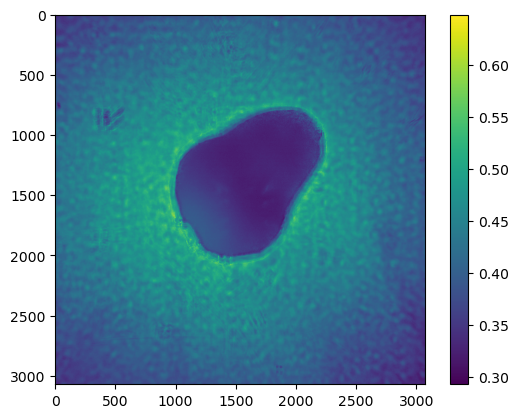

In [2]:
organoid = imread("cam6_0_baffle.bmp")/255
organoid = cp.array(organoid, dtype=cp.float32)
organoid = rgb2gray(organoid)
plt.imshow(organoid.get())
plt.colorbar()

0.3348252475261688 0.6743715405464172


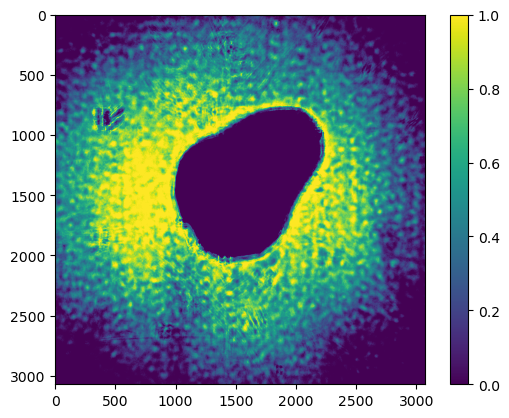

In [3]:
organoid_aeq = equalize_adapthist(organoid, kernel_size=451, nbins=256, clip_limit=0.005)
# organoid_itn_rescale = skimage.exposure.adjust_sigmoid(organoid, 0.5)
# organoid_itn_rescale = skimage.exposure.adjust_gamma(organoid, 1.5)
# organoid_itn_rescale = organoid
p25, p75 = np.percentile(organoid_aeq.get(), (25, 95))
print(p25, p75)
organoid_itn_rescale = rescale_intensity(organoid_aeq, (p25, p75))
plt.imshow(organoid_itn_rescale.get())
plt.colorbar()

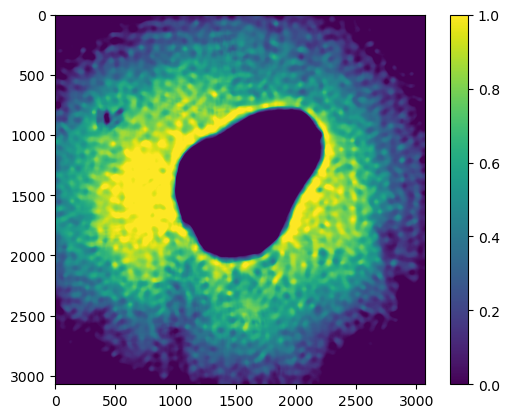

In [4]:
# organoid_rescaled_gb = scipy.ndimage.gaussian_filter(organoid_itn_rescale, sigma=5)
organoid_rescaled_mb = spx.ndimage.median_filter(organoid_itn_rescale, size=51)
plt.imshow(organoid_rescaled_mb.get())
plt.colorbar()

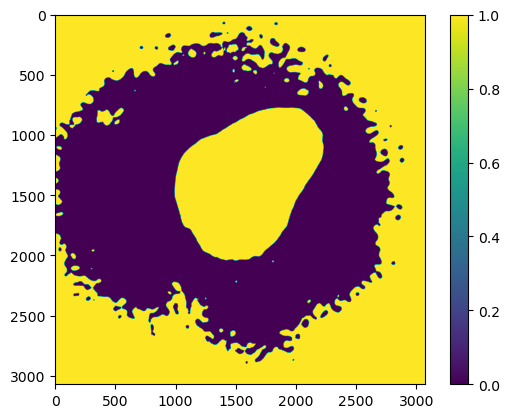

In [5]:
# organoid_adapt_th = organoid_itn_rescale < skimage.filters.threshold_local(organoid_itn_rescale, block_size=1001, method='gaussian')
organoid_otsu_th = organoid_rescaled_mb < threshold_otsu(organoid_rescaled_mb, nbins=256)
# organoid_otsu_th = organoid_itn_rescale < skimage.filters.threshold_otsu(organoid_itn_rescale, nbins=256)
plt.imshow(organoid_otsu_th.get())
plt.colorbar()

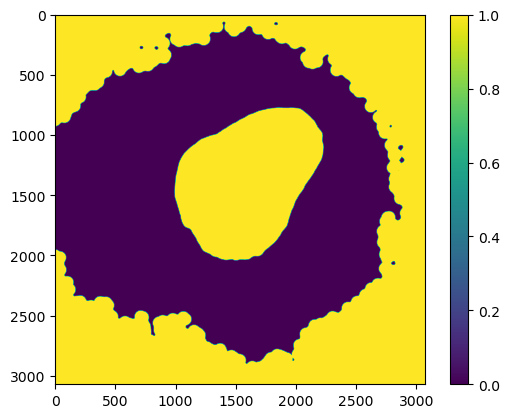

In [6]:
footprint = disk(51)
organoid_th_closed = opening(organoid_otsu_th, footprint=footprint)
plt.imshow(organoid_th_closed.get())
plt.colorbar()

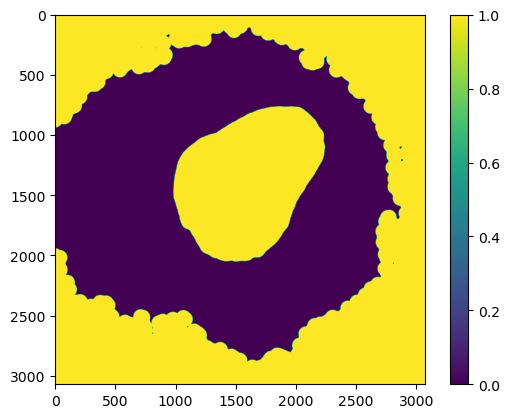

In [7]:
footprint = disk(11)
organoid_th_closed = binary_dilation(organoid_th_closed, footprint=footprint)
# organoid_th_closed = 1-organoid_th_closed
plt.imshow(organoid_th_closed.get())
plt.colorbar()

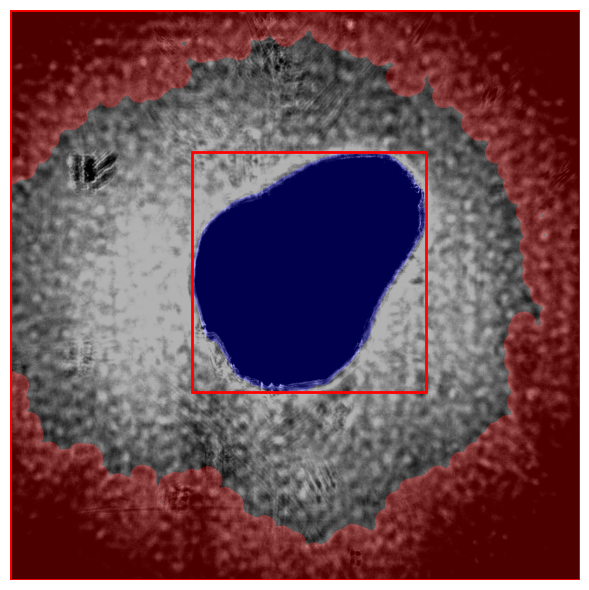

In [8]:
organoid_th_closed = organoid_th_closed.get()
org_label = skimage.measure.label(organoid_th_closed, connectivity=2)
image_label_overlay = skimage.color.label2rgb(org_label, image=organoid_itn_rescale.get(), bg_label=0)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

import matplotlib.patches as mpatches
for region in regionprops(org_label):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [9]:
def pixelcount(regionmask):
    return np.sum(regionmask)
regions = skimage.measure.regionprops_table(org_label, organoid_itn_rescale, extra_properties=(pixelcount,))
data = pd.DataFrame(regions)
data = data.sort_values(by=["pixelcount"], ascending=False)
data


,label,bbox-0,bbox-1,bbox-2,bbox-3,pixelcount
0,1,0,0,3072,3072,3848155
1,2,765,982,2057,2242,1142828


Random Walker


p25, p75 = np.percentile(organoid, (25, 75))
print(p25, p75)
data = skimage.exposure.rescale_intensity(organoid, (p25, p75))

markers = np.zeros(data.shape, dtype=np.uint)
markers[data < -0.95] = 1
markers[data > 0.95] = 2

# Run random walker algorithm
labels = skimage.segmentation.random_walker(data, markers, beta=10, mode='bf')

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3.2),
                                    sharex=True, sharey=True)
ax1.imshow(data, cmap='gray')
ax1.axis('off')
ax1.set_title('Noisy data')
ax2.imshow(markers, cmap='magma')
ax2.axis('off')
ax2.set_title('Markers')
ax3.imshow(labels, cmap='gray')
ax3.axis('off')
ax3.set_title('Segmentation')

fig.tight_layout()
plt.show()